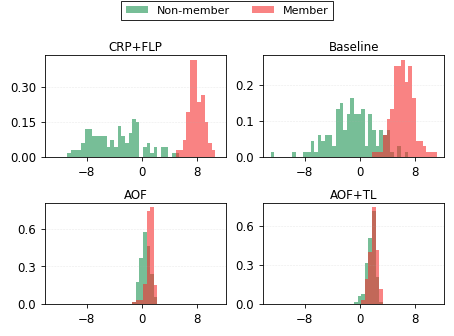

In [ ]:
"""
    Plot per-sample score distributions across multiple benchmarks (e.g., Baseline, AOF, AOF+TL).
    
    Context:
      • LiRA models member vs. non-member (IN/OUT) score distributions per sample using shadow models.
        Visualizing histograms side-by-side helps see how much IN/OUT overlap exists for a given sample
        under each training setup, and whether AOF/TL compress these distributions (less leakage). 
      • Using a compact 2×2 grid supports quick comparison of benchmarks discussed in the paper:
        Baseline, AOF, AOF (aug/regularization), and AOF+TL (transfer learning). 
      • When `single_sample=True`, we pull the column for one candidate x (the paper studies per-sample
        effects and reproducibility), matching how online/offline LiRA reason about an individual sample. 

    Author: Najeeb Jebreel, optmized by Cloude Sonnet 4.5
    Date: 2025
    """



import os, numpy as np, matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ---------- UTILITIES ----------
def _freedman_diaconis_bins(values, max_bins=80, min_bins=50):
    """
    Choose a data-adaptive number of histogram bins using the Freedman–Diaconis rule.
    This scales with the sample's interquartile range (IQR) and count, yielding
    robust density estimates even when the score range tightens under AOF/TL,
    where IN/OUT separation shrinks and tails matter most at low FPR. 
    See discussion on low-FPR regimes and reduced separability after AOF/TL. 
    """
    v = np.asarray(values, dtype=float)
    v = v[np.isfinite(v)]
    if v.size < 2:
        return min_bins
    iqr = np.subtract(*np.percentile(v, [75, 25]))
    if iqr <= 0:
        # fallback: ~sqrt(n), clipped to bounds — helpful when scores collapse (well-generalized models)
        return min(max(min_bins, int(np.sqrt(v.size))), max_bins)
    bw = 2 * iqr * (v.size ** (-1 / 3))
    if bw <= 0:
        return min(max(min_bins, int(np.sqrt(v.size))), max_bins)
    n_bins = int(np.ceil((v.max() - v.min()) / bw))
    return int(np.clip(n_bins, min_bins, max_bins))


# ---------- MAIN FUNCTION ----------
def plot_sample_inout_distributions(
    sample_idx,
    single_sample = True,
    share_xlim=True,
    save_path="figure_sample_inout.pdf",
    color_member="#F53030",     # member (IN) — red
    color_nonmember="#1C9452",  # non-member (OUT) — green
    font_family="DejaVu Sans",
    base_fontsize=8.5
):
    

    # --- typography & thin strokes suitable for PDF export (camera-ready style) ---
    plt.rcParams.update({
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.family": font_family,
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize,
        "axes.labelsize": base_fontsize - 0.5,
        "legend.fontsize": base_fontsize - 0.5,
        "axes.linewidth": 0.6,
        "grid.linewidth": 0.4,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
    })

    # --- load membership labels once (shape M×N: shadow models × samples) ---
    # Each row corresponds to a shadow 'target' setting; each column to a sample index, consistent with the
    # leave-one-out and shadow-based evaluation ideas in the paper. 
    labels = np.load(os.path.join(exp_paths[0], labels_fname))  # (M, N)
    M, N = labels.shape
    assert 0 <= sample_idx < N, f"sample_idx {sample_idx} out of range [0, {N-1}]"
    if single_sample:
        # For per-sample visualization, take the column y[:, j] to split IN (members) vs OUT.
        y = labels[:, sample_idx].astype(bool)
    else:
        # For an aggregate view (less common for interpretability), flatten all labels.
        y = labels.astype(bool)

    bench_scores = {}
    xmins, xmaxs = [], []

    # --- collect scores for each benchmark (same shape as labels) ---
    # Scores here can be "global_scores_leave_one_out" (online-like) or likelihood ratios/proxies;
    # the paper evaluates both online and offline LiRA endpoints — this plot is agnostic to the
    # exact score as long as higher ⇒ more likely to be member. 
    for bench, p in zip(benchmarks, exp_paths):
        s = np.load(os.path.join(p, scores_fname))
        assert s.shape == labels.shape, f"Shape mismatch for {bench}"
        scores_j = s[:, sample_idx].astype(np.float64) if single_sample else s.astype(np.float64)
        bench_scores[bench] = scores_j

        # Track overall min/max to optionally align x-axes, enabling like-for-like comparison
        # across Baseline → AOF → AOF+TL, which the paper shows tightens distributions. 
        finite_scores = scores_j[np.isfinite(scores_j)]
        if finite_scores.size:
            xmins.append(finite_scores.min())
            xmaxs.append(finite_scores.max())

    # --- compute a shared x-range (optional) so panels are directly comparable ---
    if share_xlim and xmins and xmaxs:
        xlo, xhi = min(xmins), max(xmaxs)
        pad = 0.05 * (xhi - xlo + 1e-12)
    else:
        xlo = xhi = pad = None

    # --- figure: compact 2×2 grid to mirror the 4 benchmark slots used in the study ---
    fig, axes = plt.subplots(2, 2, figsize=(4.6, 3.3))  # small, camera-ready footprint
    axes = axes.ravel()

    for ax, bench in zip(axes, benchmarks):
        s = bench_scores[bench]
        s_member = s[y]     # IN distribution (members)
        s_nonmember = s[~y] # OUT distribution (non-members)

        # Use a common bin rule per panel to reduce visual artifacts when tails are sparse.
        bins = _freedman_diaconis_bins(np.concatenate([s_member, s_nonmember]))

        # Determine x-range:
        #  - Shared across panels (preferred) highlights how AOF/TL compresses ranges and reduces overlap margins.
        #  - Otherwise, compute a local pad per panel.
        if share_xlim and xlo is not None:
            xrange = (xlo - pad, xhi + pad)
        else:
            finite = np.concatenate([s_member[np.isfinite(s_member)], s_nonmember[np.isfinite(s_nonmember)]])
            lo, hi = finite.min(), finite.max()
            pad_local = 0.05 * (hi - lo + 1e-12)
            xrange = (lo - pad_local, hi + pad_local)

        # --- plot IN/OUT histograms (density) ---
        # Overlaying densities makes IN/OUT overlap explicit; reduced separability after AOF/TL
        # connects to the PPV degradation under shadow-thresholds and skewed priors. 
        ax.hist(s_nonmember, bins=bins, range=xrange, density=True,
                color=color_nonmember, alpha=0.6, label="Non-member", edgecolor="none")
        ax.hist(s_member, bins=bins, range=xrange, density=True,
                color=color_member, alpha=0.6, label="Member", edgecolor="none")

        # --- aesthetics: light grid, coarse ticks for compactness ---
        ax.set_title(bench, pad=3)
        ax.grid(axis="y", alpha=0.25, ls="--", lw=0.4)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
        if share_xlim and xlo is not None:
            ax.set_xlim(xrange)
        ax.tick_params(width=0.6)

    # --- shared legend at top (Member / Non-member) ---
    handles, labels_ = axes[0].get_legend_handles_labels()
    leg = fig.legend(handles, labels_, loc="upper center", ncol=2, frameon=True,
                     borderaxespad=0.1, edgecolor='black', fancybox=False, framealpha=1.0)
    leg.get_frame().set_linewidth(0.6)

    # --- tighter layout; leave a small top margin for the legend ---
    fig.tight_layout(rect=[0, 0, 1, 0.94], h_pad=0.8, w_pad=0.8)

    # --- save vector PDF and high-DPI PNG
    if save_path:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight")
        fig.savefig(save_path.replace(".pdf", ".png"), dpi=600, bbox_inches="tight")

    plt.show()


# ---- CONFIG (adapt to your experiment folders) ----
# Benchmarks align with the paper’s taxonomy:
#   Baseline (higher loss-wise overfitting), AOF (anti-overfitting), AOF+TL (transfer learning on top of AOF),
#   etc. Their progressive regularization generally compresses IN/OUT distributions and reduces LiRA success. 
exp_paths = [
    "d:/mona/lira_analysis/experiments/cifar10/resnet18/2025-10-15_1828/",                       # weak generalization
    "d:/mona/lira_analysis/experiments/cifar10/resnet18/2025-10-17_1520/",                     # baseline
    "d:/mona/lira_analysis/experiments/cifar10/resnet18/2025-10-19_1230/",  # AOF
    "d:/mona/lira_analysis/experiments/cifar10/efficientnetv2_rw_s/2025-10-21_1440",        # AOF+TL
]
benchmarks = ["CRP+FLP", "Baseline", "AOF", "AOF+TL"]

# File names:
#  - scores_fname: per-(shadow, sample) score; higher should indicate "more likely member".
#    In the paper, online LiRA relies on IN/OUT modeling; offline variants use OUT tails; both
#    can be summarized as scalar scores for plotting. :c
#  - labels_fname: boolean membership labels for each (shadow, sample) used to split histograms. 
scores_fname = "global_scores_leave_one_out.npy" # or "likelihood_ratios_online_leave_one_out.npy" for likelihood ratios
labels_fname = "membership_labels.npy"

# Example: visualize one sample’s IN/OUT distributions across benchmarks.
# This lets you see whether a “vulnerable” sample under Baseline remains so under AOF/TL,
# tying directly to the paper’s observations about reduced precision and reproducibility. 
plot_sample_inout_distributions(
    sample_idx=21,
    save_path="figures/sample_inout_score.pdf",
    single_sample=True
)
